# Real Estate Benchmarking/Market Understanding
## Info:
    Creator: ( Mavor, Chris)
    Date: (August 24, 2022)
## Usage: 
    The purpose of this script is to showcase usage of data extraction from API resource to develop datasets to perform statistical understanding of housing market as it relates to current company's geographic location.
    This script performs a deeper learning and analysis of such data. This is following the data extraction from https://theexchange.fanniemae.com/ API. For more on that matter please refer back to "01.Fannie API.ipynb"
    
    Specific items that relate to company performance have been ommited to keep animinity and keep secure information from public knowledge.
## Outline:
    1. API Data requests:
        Get the data
    2. Data manipulation: 
        a. Parsing through json data array to create flat dataframe for each portion. 
        b. Gathering different metrics from different storage bins.
    3. Storage: 
        After manipulation is completed, I am storing said information as a flat file for ease of further analysis.

## Next Steps:
    Following this data gathering, I use other methods for deeper learning on topics in which I have gathered here.


## 1.0 - Import

In [1]:
#importing all packages needed and unneeded

#SQL
import cx_Oracle
import sqlite3
import getpass
import pyodbc 

# stats/science
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy import stats
import matplotlib # not particularly important at the moment
import matplotlib.pyplot as plt # not particularly important at the moment
from matplotlib.lines import Line2D
import seaborn as sns # not particularly important at the moment

  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import operator
from sklearn.preprocessing import PolynomialFeatures

# date packages
import datetime as dt
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import calendar
# creating accounting triangles

import chainladder as cl
# packages needed during AWS opperations
import sys
import os 

from openpyxl import load_workbook
import xlsxwriter
from heapq import merge


# from pptx import Presentation


#__________________________________________________________
#set the display options for the notebook
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#__________________________________________________________
#set username and password for database connection

In [2]:
#setting time variables used for automated report usage
today_yyyymm = dt.datetime.today()
first_day = today_yyyymm.replace(day = 1)
last_month_yyyymm = first_day - dt.timedelta(days=1)
previous_yyyymm = last_month_yyyymm.strftime("%Y%m")
current_yyyymm = today_yyyymm.strftime("%Y%m")

print(current_yyyymm,previous_yyyymm)

202211 202210


## 2.0 - Data Grab
Grab Data


In [3]:
# Gathering data sets for analysis
ntx_zips = pd.read_excel(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\NTX_zips.xlsx',sheet_name="Sheet1") #sheet of Geo zips within opperation range
city_zips = pd.read_excel(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\ZipCodes.xlsx',sheet_name="Zip Code Data") #specific zipcodes in city limits
#_______________
inventory = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\RDC_Inventory_ZIP.csv') #RealtorDotCom monthly data produced for Inventory
hotness = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\RDC_Hotness_ZIP_202208.csv') #RealtorDotCom monthly data produced for "Hotness" calculation
migration = pd.read_excel(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\RedFin_Migration_CITY.xlsx',sheet_name = 'Net Flow Metros') #RedFin data produced for Migration (quarterly)

ValueIndex = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\Z_ValueIndex_ALLHOMES_ZIP.csv') #Zillow data produced for Home Value
ValueForecast = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\Z_ValueForecast_ALLHOMES_ZIP.csv') #Zillow data produced for Forcasted Value
sales = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\Z_SaleCount_ALLHOMES_CITY.csv')#Zillow data produced for Sale Counts
saleprice = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\Z_SalePrice_ALLHOMES_CITY.csv')#Zillow data produced for Sale Counts
listprice = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\Z_ListPrice_ALLHOMES_CITY.csv')#Zillow data produced for Sale Counts


rates = pd.read_csv(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\Freddie_Rates.csv') #Freddie Weekly/daily updates for current average 30yr Mortgage rates based on all purchased mortgages
indi = pd.read_excel(r'W:\LENDING\REAL ESTATE\BPA\Chris Mavor\00.General_Data\MarketData\FannieData.xlsx',sheet_name="data") # this follows the "01.Fannie API.ipynb" script that gathers metrics pertaining to this analysis

leads = pd.read_csv(r'W:\LENDING\REAL ESTATE\Reports\Velocify\All_Leads_All_Data.csv') # internal data anonomized for aminimity



c:\Users\chris.mavor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\chris.mavor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\chris.mavor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (26,29,33,52,57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 3.0 Work Data
 Data Split Creation

In [4]:
#Migration Reshape
migration = migration[['Time','City','State','Net']]
migration['Time'] = migration['Time'].astype(str).str[0:4]+migration['Time'].astype(str).str[5:7]


In [5]:
#Shrink Data to Just NTX

ntx_list = ntx_zips['Zip'].astype(int).tolist() # list creation of zip data
inventory = inventory[inventory['postal_code'].isin(ntx_list)].reset_index(drop = True) #using list boolean filtering
hotness = hotness[hotness['postal_code'].isin(ntx_list)].reset_index(drop = True)
ValueIndex = ValueIndex[ValueIndex['RegionName'].isin(ntx_list)].reset_index(drop = True)
ValueForecast = ValueForecast[ValueForecast['RegionName'].isin(ntx_list)].reset_index(drop = True)
city_zips = city_zips[city_zips['zip'].isin(ntx_list)].reset_index(drop = True)
migration = migration[migration['State']=='TX']
city_list = city_zips['primary_city'].tolist()
migration = migration[migration['City'].isin(city_list)].reset_index(drop = True)


In [6]:
# Rename columns in ValueIndex Dataset
# reform the data form 
# each month is sorted across multiple column (already pivoted), I needed data to be stacked in a single column per measurement in order to pivot funtion instead of a date table.
# Essential break down
# City  8/1/2019    9/1/2019...
# Dallas    10000   20000...

# reformat to
# City  Date    Value
# Dallas    8/1/2019    10000
# Dallas    9/1/2019    20000   
Value_columns = sales.columns.values.tolist()
Value_columns_dates = Value_columns[5:len(Value_columns)]
Value_columns_names = Value_columns[0:5]
datelist=[]
# for loop that opperates through column values and appends them to a list of dates refomrated in YYYYMM
for i in Value_columns_dates:
    new = i[len(i)-len(i):i.find('/')]+i[len(i)-4:len(i)]
    if len(new) == 6:
        new = new
    else:
        new = '0'+new
        
    final = new[2:7]+new[0:2]
    datelist.append(final)
ValueIndexColumns = Value_columns_names + datelist
sales.columns = ValueIndexColumns
# melting column names into an unpivoted data format to follow an easier unpivoted datastructure
stacked_sales = sales.melt(id_vars = Value_columns_names )
stacked_sales = stacked_sales[(stacked_sales['RegionName']=="Dallas, TX")]
stacked_sales = stacked_sales.rename(columns={'variable':'YYYYMM', 'value':'Sales'})
stacked_sales.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,YYYYMM,Sales
4,394514,4,"Dallas, TX",msa,TX,200802,4496.0
98,394514,4,"Dallas, TX",msa,TX,200803,5445.0
192,394514,4,"Dallas, TX",msa,TX,200804,6209.0
286,394514,4,"Dallas, TX",msa,TX,200805,6465.0
380,394514,4,"Dallas, TX",msa,TX,200806,6668.0


In [7]:
# Rename columns in ValueIndex Dataset
# reform the data form 
# each month is sorted across multiple column (already pivoted), I needed data to be stacked in a single column per measurement in order to pivot funtion instead of a date table.
# Essential break down
# City  8/1/2019    9/1/2019...
# Dallas    10000   20000...

# reformat to
# City  Date    Value
# Dallas    8/1/2019    10000
# Dallas    9/1/2019    20000   
Value_columns = saleprice.columns.values.tolist()
Value_columns_dates = Value_columns[5:len(Value_columns)]
Value_columns_names = Value_columns[0:5]
datelist=[]
# for loop that opperates through column values and appends them to a list of dates refomrated in YYYYMM
for i in Value_columns_dates:
    new = i[len(i)-len(i):i.find('/')]+i[len(i)-4:len(i)]
    if len(new) == 6:
        new = new
    else:
        new = '0'+new
        
    final = new[2:7]+new[0:2]
    datelist.append(final)
ValueIndexColumns = Value_columns_names + datelist
saleprice.columns = ValueIndexColumns
# melting column names into an unpivoted data format to follow an easier unpivoted datastructure
stacked_saleprice = saleprice.melt(id_vars = Value_columns_names )
stacked_saleprice = stacked_saleprice[(stacked_saleprice['RegionName']=="Dallas, TX")]
stacked_saleprice = stacked_saleprice.rename(columns={'variable':'YYYYMM', 'value':'SalePrice'})
stacked_saleprice.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,YYYYMM,SalePrice
4,394514,4,"Dallas, TX",msa,TX,200804,141850.0
631,394514,4,"Dallas, TX",msa,TX,200805,144817.0
1258,394514,4,"Dallas, TX",msa,TX,200806,148317.0
1885,394514,4,"Dallas, TX",msa,TX,200807,152300.0
2512,394514,4,"Dallas, TX",msa,TX,200808,154000.0


In [8]:
# Rename columns in ValueIndex Dataset
# reform the data form 
# each month is sorted across multiple column (already pivoted), I needed data to be stacked in a single column per measurement in order to pivot funtion instead of a date table.
# Essential break down
# City  8/1/2019    9/1/2019...
# Dallas    10000   20000...

# reformat to
# City  Date    Value
# Dallas    8/1/2019    10000
# Dallas    9/1/2019    20000   
Value_columns = listprice.columns.values.tolist()
Value_columns_dates = Value_columns[5:len(Value_columns)]
Value_columns_names = Value_columns[0:5]
datelist=[]
# for loop that opperates through column values and appends them to a list of dates refomrated in YYYYMM
for i in Value_columns_dates:
    new = i[len(i)-len(i):i.find('/')]+i[len(i)-4:len(i)]
    if len(new) == 6:
        new = new
    else:
        new = '0'+new
        
    final = new[2:7]+new[0:2]
    datelist.append(final)
ValueIndexColumns = Value_columns_names + datelist
listprice.columns = ValueIndexColumns
# melting column names into an unpivoted data format to follow an easier unpivoted datastructure
stacked_listprice = listprice.melt(id_vars = Value_columns_names )
stacked_listprice = stacked_listprice[(stacked_listprice['RegionName']=="Dallas, TX")]
stacked_listprice = stacked_listprice.rename(columns={'variable':'YYYYMM', 'value':'ListPrice'})
stacked_listprice.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,YYYYMM,ListPrice
4,394514,4,"Dallas, TX",msa,TX,201803,325253.0
902,394514,4,"Dallas, TX",msa,TX,201804,330319.0
1800,394514,4,"Dallas, TX",msa,TX,201805,333613.0
2698,394514,4,"Dallas, TX",msa,TX,201806,333632.0
3596,394514,4,"Dallas, TX",msa,TX,201807,330298.0


In [9]:
# Following similar opperations as above to help simplify data operations
Value_columns = ValueIndex.columns.values.tolist()
Value_columns_dates = Value_columns[9:len(Value_columns)]
Value_columns_names = Value_columns[0:9]
datelist=[]
for i in Value_columns_dates:
    new = i[len(i)-len(i):i.find('/')]+i[len(i)-4:len(i)]
    if len(new) == 6:
        new = new
    else:
        new = '0'+new
        
    final = new[2:7]+new[0:2]
    datelist.append(final)
ValueIndexColumns = Value_columns_names + datelist
ValueIndex.columns = ValueIndexColumns
stacked_value = ValueIndex.melt(id_vars = Value_columns_names )
stacked_value = stacked_value.rename(columns={'variable':'YYYYMM', 'value':'HomeValue'})

In [10]:
# Following similar opperations as above to help simplify data operations
Forecast_columns = ValueForecast.columns.values.tolist()
Forecast_columns_dates = Forecast_columns[10:len(Forecast_columns)]
Forecast_columns_names = Forecast_columns[0:10]
datelist=[]
for i in Forecast_columns_dates:
    new = i[len(i)-len(i):i.find('/')]+i[len(i)-4:len(i)]
    if len(new) == 6:
        new = new
    else:
        new = '0'+new
        
    final = new[2:7]+new[0:2]
    datelist.append(final)
ForecastColumns = Forecast_columns_names + datelist
ValueForecast.columns = ForecastColumns

In [11]:
# getting forecast date and value to be home value to add to other dataframe so that they are on same trend line
stacked_forecast = ValueForecast.melt(id_vars = Forecast_columns_names )
m = str(int(stacked_forecast['variable'].min())-1)
value_addon = stacked_value[stacked_value['YYYYMM']==m]
stacked_forecastadd = stacked_forecast.merge(value_addon
                                             , left_on=['RegionID','SizeRank','RegionName','RegionType','StateName','State','City','Metro','CountyName']
                                             , right_on=['RegionID','SizeRank','RegionName','RegionType','StateName','State','City','Metro','CountyName']
                                            ,how = 'left')
stacked_forecastadd['Forecast'] = (1+(stacked_forecastadd['value']/100))*stacked_forecastadd['HomeValue']
stacked_forecastadd = stacked_forecastadd[['RegionID','SizeRank','RegionName','RegionType'
                                          ,'StateName','State','City','Metro','CountyName','variable','Forecast']]
stacked_forecastadd = stacked_forecastadd.rename(columns={'variable':'YYYYMM'})
stacked_value_and_forecast = stacked_value.merge(stacked_forecastadd
                                             , left_on=['RegionID','SizeRank','RegionName','RegionType','StateName','State','City','Metro','CountyName','YYYYMM']
                                             , right_on=['RegionID','SizeRank','RegionName','RegionType','StateName','State','City','Metro','CountyName','YYYYMM']
                                            ,how = 'outer')
stacked_value_and_forecast['YYYYMM'] = stacked_value_and_forecast['YYYYMM'].astype(int)

stacked_value_and_forecast['YYYYMM'] = stacked_value_and_forecast['YYYYMM'].astype(int)
stacked_value_and_forecast['Year'] = stacked_value_and_forecast['YYYYMM'].astype(str).str[0:4].astype(int)
stacked_value_and_forecast['Month'] = stacked_value_and_forecast['YYYYMM'].astype(str).str[4:6].astype(int)
stacked_value_and_forecast['YYYYMM'] = stacked_value_and_forecast['YYYYMM'].astype(int)

stacked_value_and_forecast.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,YYYYMM,HomeValue,Forecast,Year,Month
0,90654,34,75052,zip,TX,TX,Grand Prairie,"Dallas-Fort Worth-Arlington, TX",Dallas County,200001,113011.0,NaN,2000,1
1,90769,57,75217,zip,TX,TX,Dallas,"Dallas-Fort Worth-Arlington, TX",Dallas County,200001,70353.0,NaN,2000,1
2,90764,94,75211,zip,TX,TX,Cockrell Hill,"Dallas-Fort Worth-Arlington, TX",Dallas County,200001,79429.0,NaN,2000,1
3,91221,124,76063,zip,TX,TX,Mansfield,"Dallas-Fort Worth-Arlington, TX",Tarrant County,200001,160873.0,NaN,2000,1
4,90780,130,75228,zip,TX,TX,Dallas,"Dallas-Fort Worth-Arlington, TX",Dallas County,200001,98812.0,NaN,2000,1


In [12]:
stacked_inventory = inventory.copy()

stacked_inventory = stacked_inventory.rename(columns = {'postal_code':"RegionName","month_date_yyyymm":"YYYYMM"})

stacked_inventory = stacked_inventory[['YYYYMM','RegionName','zip_name','median_listing_price',
       'median_listing_price_mm', 'median_listing_price_yy',
       'active_listing_count', 'active_listing_count_mm',
       'active_listing_count_yy', 'median_days_on_market',
       'median_days_on_market_mm', 'median_days_on_market_yy',
       'new_listing_count', 'new_listing_count_mm', 'new_listing_count_yy',
       'price_increased_count', 'price_increased_count_mm',
       'price_increased_count_yy', 'price_reduced_count',
       'price_reduced_count_mm', 'price_reduced_count_yy',
       'pending_listing_count', 'pending_listing_count_mm',
       'pending_listing_count_yy', 'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_listing_count',
       'total_listing_count_mm', 'total_listing_count_yy', 'pending_ratio',
       'pending_ratio_mm', 'pending_ratio_yy', 'quality_flag']]

stacked_inventory['YYYYMM'] = stacked_inventory['YYYYMM'].astype(int)

inventory_min_month = stacked_inventory['YYYYMM'].min()

stacked_inventory.head()

,YYYYMM,RegionName,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_listing_count,pending_listing_count_mm,pending_listing_count_yy,median_listing_price_per_square_foot,median_listing_price_per_square_foot_mm,median_listing_price_per_square_foot_yy,median_square_feet,median_square_feet_mm,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag
0,202205,76126,"fort worth, tx",599900.0,0.0911,0.3634,62.0,0.1071,0.6316,43.0,0.3710,-0.0116,76.0,-0.0952,0.2667,4.0,-0.75,0.0,20.0,0.0,1.5,114.0,0.0364,0.1287,235.0,0.0375,0.3617,2542.0,0.0115,0.0526,937167.0,0.1940,0.2807,183.0,0.1296,0.3165,1.8387,-0.1256,-0.8192,1.0
1,202205,75074,"plano, tx",432500.0,0.0422,0.2357,31.0,0.8235,0.8235,19.0,-0.3621,-0.2885,56.0,0.1667,0.0769,0.0,-1.00,NaN,8.0,1.0,1.0,46.0,0.0698,-0.1321,233.0,0.0546,0.3371,1958.0,-0.0053,-0.1110,474602.0,0.0837,0.2979,76.0,0.2258,0.0857,1.4839,-1.0455,-1.6338,1.0
2,202205,76092,"southlake, tx",1499940.0,-0.1161,0.0909,49.0,0.3243,0.2250,25.0,-0.2188,-0.2188,64.0,-0.0588,0.0000,0.0,NaN,NaN,12.0,2.0,2.0,61.0,0.1509,-0.1867,356.0,-0.0158,0.2396,4329.0,-0.0959,-0.1089,2202048.0,-0.1192,0.0740,110.0,0.2500,-0.0435,1.2449,-0.1875,-0.6301,1.0
3,202205,75220,"dallas, tx",1474250.0,-0.0171,0.8521,33.0,0.0313,-0.0833,31.0,0.4091,-0.2955,32.0,-0.2727,0.6000,0.0,-1.00,NaN,0.0,-1.0,-1.0,46.0,-0.1930,0.0952,407.0,0.0088,0.2760,3715.0,-0.0125,0.2212,3171439.0,-0.0909,0.8138,81.0,-0.0795,0.0385,1.3939,-0.3873,0.2273,1.0
4,202205,75109,"corsicana, tx",649900.0,0.0398,-0.4924,17.0,0.0625,1.4286,29.0,-0.0172,-0.3049,8.0,-0.3333,NaN,0.0,NaN,NaN,8.0,1.0,NaN,13.0,0.0833,1.6000,240.0,0.0687,0.2879,2755.0,0.0249,-0.3239,832528.0,0.1717,-0.1190,30.0,0.0714,1.3077,0.7647,0.0147,0.0504,1.0


In [13]:
stacked_hotness = hotness[['month_date_yyyymm', 'postal_code', 'zip_name', 'nielsen_hh_rank',
       'hotness_rank', 'hotness_rank_mm', 'hotness_rank_yy', 'hotness_score',
       'supply_score', 'demand_score',
        'median_dom_mm_day',
        'median_dom_yy_day', 'median_dom_vs_us',
       'ldp_unique_viewers_per_property_mm',
       'ldp_unique_viewers_per_property_yy',
       'ldp_unique_viewers_per_property_vs_us',
       'median_listing_price_vs_us']]

stacked_hotness = stacked_hotness.rename(columns = {'postal_code':"RegionName","month_date_yyyymm":"YYYYMM"})

stacked_hotness['YYYYMM'] = stacked_hotness['YYYYMM'].astype(int)


In [14]:
datelist = []
for i in rates['date']:
    new = i[len(i)-len(i):i.find('/')]+i[len(i)-4:len(i)]
    if len(new) == 6:
        new = new
    else:
        new = '0'+new
    final = new[2:7]+new[0:2]
    datelist.append(final)

rates['YYYYMM'] = datelist

stacked_rates = pd.pivot_table(rates, index=['YYYYMM'],values='pmms30',aggfunc=np.mean)
stacked_rates = stacked_rates.reset_index(drop = False)
stacked_rates = stacked_rates.rename(columns={'pmms30':'rate'})
stacked_rates['YYYYMM'] = stacked_rates['YYYYMM'].astype(int)
    
# print(rates.shape[0],len(datelist))

In [15]:
leads_work = leads.copy()
leads_work = leads_work[leads_work['Group']=="Purchase"]
# leads_work['YYYYMM'] = .dt.strftime()
# leads_work['YYYYMM'] = leads_work['Date Added'].astype(str).str[0:3]
leads_work['Date Added'] = pd.to_datetime(leads_work['Date Added'])

leads_work['YYYYMM'] = leads_work['Date Added'].dt.strftime("%Y%m")

stacked_leads = leads_work.groupby('YYYYMM').agg({'Id':'count'}).reset_index()
stacked_leads.head()

,YYYYMM,Id
0,202108,3306
1,202109,3107
2,202110,3125
3,202111,2958
4,202112,2919


In [16]:
indi.head()

,effective_date,year,quarter,forecast_loan,purch_mort,forecast_starts,new_home_starts,forecast_refi,refi_mort
0,2022-10-10,2007,Q1,False,235.9,False,1173.7,False,291.9
1,2022-10-10,2007,Q2,False,318.8,False,1152.7,False,309.9
2,2022-10-10,2007,Q3,False,289.0,False,978.0,False,227.6
3,2022-10-10,2007,Q4,False,222.0,False,838.7,False,273.6
4,2022-10-10,2007,EOY,False,1065.6,False,1046.0,False,1103.0


In [17]:
external_loans = indi[indi['quarter'] != "EOY"]


In [18]:
external_loans.head()

,effective_date,year,quarter,forecast_loan,purch_mort,forecast_starts,new_home_starts,forecast_refi,refi_mort
0,2022-10-10,2007,Q1,False,235.9,False,1173.7,False,291.9
1,2022-10-10,2007,Q2,False,318.8,False,1152.7,False,309.9
2,2022-10-10,2007,Q3,False,289.0,False,978.0,False,227.6
3,2022-10-10,2007,Q4,False,222.0,False,838.7,False,273.6
5,2022-10-10,2008,Q1,False,138.9,False,741.7,False,248.5


In [19]:
stacked_sales.sort_values(by='YYYYMM', ascending=False).head()

,RegionID,SizeRank,RegionName,RegionType,StateName,YYYYMM,Sales
16548,394514,4,"Dallas, TX",msa,TX,202210,6505.0
16454,394514,4,"Dallas, TX",msa,TX,202209,6782.0
16360,394514,4,"Dallas, TX",msa,TX,202208,7851.0
16266,394514,4,"Dallas, TX",msa,TX,202207,7609.0
16172,394514,4,"Dallas, TX",msa,TX,202206,8311.0


In [20]:
stacked_saleprice.sort_values(by='YYYYMM', ascending=False).head()

,RegionID,SizeRank,RegionName,RegionType,StateName,YYYYMM,SalePrice
108475,394514,4,"Dallas, TX",msa,TX,202209,403333.0
107848,394514,4,"Dallas, TX",msa,TX,202208,413667.0
107221,394514,4,"Dallas, TX",msa,TX,202207,423667.0
106594,394514,4,"Dallas, TX",msa,TX,202206,425333.0
105967,394514,4,"Dallas, TX",msa,TX,202205,413633.0


In [21]:
stacked_listprice.sort_values(by='YYYYMM', ascending=False).head()

,RegionID,SizeRank,RegionName,RegionType,StateName,YYYYMM,ListPrice
49394,394514,4,"Dallas, TX",msa,TX,202210,424000.0
48496,394514,4,"Dallas, TX",msa,TX,202209,433333.0
47598,394514,4,"Dallas, TX",msa,TX,202208,441333.0
46700,394514,4,"Dallas, TX",msa,TX,202207,444667.0
45802,394514,4,"Dallas, TX",msa,TX,202206,438000.0


# Finalizing data for visualization

In [22]:
vf = stacked_value_and_forecast.copy()
heat = stacked_hotness.copy()
inv = stacked_inventory.copy()
rate = stacked_rates.copy()
sale = stacked_sales.copy()
saleprice = stacked_saleprice.copy()
listprice = stacked_listprice.copy()
new = stacked_leads.copy()
fannie = external_loans.copy()

# Narrowing down available data and aggregating appropriately for a "stacked" format on each data set

vf = vf.groupby('YYYYMM').agg({'HomeValue':np.mean}).reset_index()
heat = heat.groupby('YYYYMM').agg({'hotness_rank':np.mean,'supply_score':np.mean,'demand_score':np.mean,'ldp_unique_viewers_per_property_mm':np.mean}).reset_index()
inv = inv.groupby('YYYYMM').agg({'median_listing_price':np.mean,'active_listing_count':np.sum ,'new_listing_count':np.sum
                                ,'price_increased_count':np.sum,'price_reduced_count':np.sum,'median_days_on_market':np.mean}).reset_index()
rate = rate.groupby('YYYYMM').agg({'rate':np.mean}).reset_index()
sale = sale.groupby('YYYYMM').agg({'Sales':np.mean}).reset_index()
saleprice = saleprice.groupby('YYYYMM').agg({'SalePrice':np.mean}).reset_index()
listprice = listprice.groupby('YYYYMM').agg({'ListPrice':np.mean}).reset_index()

sale['YYYYMM'] = sale['YYYYMM'].astype(int)
sale['Year'] = sale['YYYYMM'].astype(str).str[0:4].astype(int)
sale['Month'] = sale['YYYYMM'].astype(str).str[4:6].astype(int)
sale['YYYYMM'] = sale['YYYYMM'].astype(int)

saleprice['YYYYMM'] = saleprice['YYYYMM'].astype(int)
saleprice['Year'] = saleprice['YYYYMM'].astype(str).str[0:4].astype(int)
saleprice['Month'] = saleprice['YYYYMM'].astype(str).str[4:6].astype(int)
saleprice['YYYYMM'] = saleprice['YYYYMM'].astype(int)

listprice['YYYYMM'] = listprice['YYYYMM'].astype(int)
listprice['Year'] = listprice['YYYYMM'].astype(str).str[0:4].astype(int)
listprice['Month'] = listprice['YYYYMM'].astype(str).str[4:6].astype(int)
listprice['YYYYMM'] = listprice['YYYYMM'].astype(int)

rate['YYYYMM'] = rate['YYYYMM'].astype(int)
rate['Year'] = rate['YYYYMM'].astype(str).str[0:4].astype(int)
rate['Month'] = rate['YYYYMM'].astype(str).str[4:6].astype(int)
rate['YYYYMM'] = rate['YYYYMM'].astype(int)

inv['YYYYMM'] = inv['YYYYMM'].astype(int)
inv['Year'] = inv['YYYYMM'].astype(str).str[0:4].astype(int)
inv['Month'] = inv['YYYYMM'].astype(str).str[4:6].astype(int)
inv['YYYYMM'] = inv['YYYYMM'].astype(int)

heat['YYYYMM'] = heat['YYYYMM'].astype(int)
heat['Year'] = heat['YYYYMM'].astype(str).str[0:4].astype(int)
heat['Month'] = heat['YYYYMM'].astype(str).str[4:6].astype(int)
heat['YYYYMM'] = heat['YYYYMM'].astype(int)

vf['YYYYMM'] = vf['YYYYMM'].astype(int)
vf['Year'] = vf['YYYYMM'].astype(str).str[0:4].astype(int)
vf['Month'] = vf['YYYYMM'].astype(str).str[4:6].astype(int)
vf['YYYYMM'] = vf['YYYYMM'].astype(int)

new['YYYYMM'] = new['YYYYMM'].astype(int)
new['Year'] = new['YYYYMM'].astype(str).str[0:4].astype(int)
new['Month'] = new['YYYYMM'].astype(str).str[4:6].astype(int)
new['YYYYMM'] = new['YYYYMM'].astype(int)

In [23]:
sale.sort_values(by='YYYYMM', ascending=False).head()

,YYYYMM,Sales,Year,Month
176,202210,6505.0,2022,10
175,202209,6782.0,2022,9
174,202208,7851.0,2022,8
173,202207,7609.0,2022,7
172,202206,8311.0,2022,6


In [24]:

# deviding into year break out ot have each year overlap for YoY comparison

heat_19 = heat[heat['Year']==2019]
heat_20 = heat[heat['Year']==2020]
heat_21 = heat[heat['Year']==2021]
heat_22 = heat[heat['Year']==2022]
heat_23 = heat[heat['Year']==2023]

sale_19 = sale[sale['Year']==2019]
sale_20 = sale[sale['Year']==2020]
sale_21 = sale[sale['Year']==2021]
sale_22 = sale[sale['Year']==2022]
sale_23 = sale[sale['Year']==2023]

saleprice_19 = saleprice[saleprice['Year']==2019]
saleprice_20 = saleprice[saleprice['Year']==2020]
saleprice_21 = saleprice[saleprice['Year']==2021]
saleprice_22 = saleprice[saleprice['Year']==2022]
saleprice_23 = saleprice[saleprice['Year']==2023]

listprice_19 = listprice[listprice['Year']==2019]
listprice_20 = listprice[listprice['Year']==2020]
listprice_21 = listprice[listprice['Year']==2021]
listprice_22 = listprice[listprice['Year']==2022]
listprice_23 = listprice[listprice['Year']==2023]

rate_19 = rate[rate['Year']==2019]
rate_20 = rate[rate['Year']==2020]
rate_21 = rate[rate['Year']==2021]
rate_22 = rate[rate['Year']==2022]
rate_23 = rate[rate['Year']==2023]

inv_19 = inv[inv['Year']==2019]
inv_20 = inv[inv['Year']==2020]
inv_21 = inv[inv['Year']==2021]
inv_22 = inv[inv['Year']==2022]
inv_23 = inv[inv['Year']==2023]

vf_19 = vf[vf['Year']==2019]
vf_20 = vf[vf['Year']==2020]
vf_21 = vf[vf['Year']==2021]
vf_22 = vf[vf['Year']==2022]
vf_23 = vf[vf['Year']==2023]

new_19 = new[new['Year']==2019]
new_20 = new[new['Year']==2020]
new_21 = new[new['Year']==2021]
new_22 = new[new['Year']==2022]
new_23 = new[new['Year']==2023]

fannie_19 = fannie[fannie['year']==2019]
fannie_20 = fannie[fannie['year']==2020]
fannie_21 = fannie[fannie['year']==2021]
fannie_22 = fannie[fannie['year']==2022]
fannie_23 = fannie[fannie['year']==2023]

fannie.head()

,effective_date,year,quarter,forecast_loan,purch_mort,forecast_starts,new_home_starts,forecast_refi,refi_mort
0,2022-10-10,2007,Q1,False,235.9,False,1173.7,False,291.9
1,2022-10-10,2007,Q2,False,318.8,False,1152.7,False,309.9
2,2022-10-10,2007,Q3,False,289.0,False,978.0,False,227.6
3,2022-10-10,2007,Q4,False,222.0,False,838.7,False,273.6
5,2022-10-10,2008,Q1,False,138.9,False,741.7,False,248.5


In [25]:
pivotttt = pd.pivot_table(inv[inv['Year']==2022], index=['YYYYMM'],values=['new_listing_count'])

pivotttt.head(200)

,new_listing_count
YYYYMM,
202201,6748.0
202202,7452.0
202203,9492.0
202204,11608.0
202205,13608.0
202206,14676.0
202207,13604.0
202208,11444.0
202209,12608.0


# Visualization

In [26]:
# pip install simple_colors

In [27]:
from simple_colors import *
print(green('Hello', ['bold']))

Hello


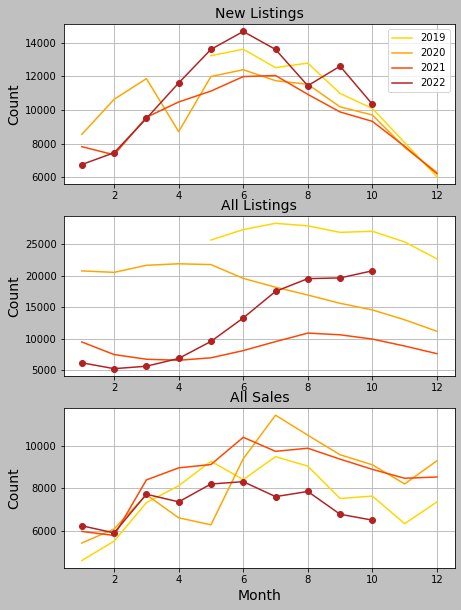

This Figure is to show how time affects inventory with relation to North Texas Residential Real Estate.


In [28]:
# Creating Visualizations for pertinant data
# Using multiple figures on a single plot to allow fore like information to be held together in a single image fore reporting purposes. 

fig, axs = plt.subplots(3, figsize=(7,10),facecolor="silver") 


legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='orange',label='2020'),
                   Line2D([0], [0], color='orangered', label='2021'),
                   Line2D([0], [0], color='firebrick',label='2022')]
axs[0].legend(handles=legend_elements, loc='best')

axs[0].plot(inv_19['Month'][inv_19["YYYYMM"]>=201905], inv_19['new_listing_count'][inv_19["YYYYMM"]>=201905], color='gold')
axs[0].plot(inv_20['Month'], inv_20['new_listing_count'], color='orange')
axs[0].plot(inv_21['Month'], inv_21['new_listing_count'], color='orangered')
axs[0].plot(inv_22['Month'], inv_22['new_listing_count'], color='firebrick', marker='o')
axs[0].set_title('New Listings', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[0].grid(True)

axs[1].plot(inv_19['Month'][inv_19["YYYYMM"]>=201905], inv_19['active_listing_count'][inv_19["YYYYMM"]>=201905], color='gold')
axs[1].plot(inv_20['Month'], inv_20['active_listing_count'], color='orange')
axs[1].plot(inv_21['Month'], inv_21['active_listing_count'], color='orangered')
axs[1].plot(inv_22['Month'], inv_22['active_listing_count'], color='firebrick', marker='o')
axs[1].set_title('All Listings', fontsize=14)
axs[1].set_ylabel('Count', fontsize=14)
axs[1].grid(True)

axs[2].plot(sale_19['Month'], sale_19['Sales'], color='gold')
axs[2].plot(sale_20['Month'], sale_20['Sales'], color='orange')
axs[2].plot(sale_21['Month'], sale_21['Sales'], color='orangered')
axs[2].plot(sale_22['Month'], sale_22['Sales'], color='firebrick', marker='o')
axs[2].set_title('All Sales', fontsize=14)
axs[2].set_ylabel('Count', fontsize=14)
axs[2].grid(True)

plt.xlabel('Month', fontsize=14)
plt.savefig("listings.png", dpi = 150,bbox_inches='tight')
plt.show()
print(green('This Figure is to show how time affects inventory with relation to North Texas Residential Real Estate.', ['bold']))

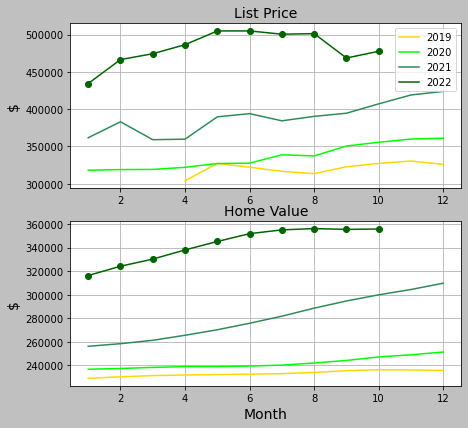

In [29]:
fig, axs = plt.subplots(2, figsize=(7,6.666),facecolor="silver") 

legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='lime',label='2020'),
                   Line2D([0], [0], color='seagreen', label='2021'),
                   Line2D([0], [0], color='darkgreen',label='2022')]

axs[0].legend(handles=legend_elements, loc='upper right')
axs[0].plot(inv_19['Month'], inv_19['median_listing_price'], color='gold')
axs[0].plot(inv_20['Month'], inv_20['median_listing_price'], color='lime')
axs[0].plot(inv_21['Month'], inv_21['median_listing_price'], color='seagreen')
axs[0].plot(inv_22['Month'], inv_22['median_listing_price'], color='darkgreen', marker='o')
axs[0].set_title('List Price', fontsize=14)
axs[0].grid(True)
axs[0].set_ylabel('$', fontsize=14)

axs[1].plot(vf_19['Month'], vf_19['HomeValue'], color='gold')
axs[1].plot(vf_20['Month'], vf_20['HomeValue'], color='lime')
axs[1].plot(vf_21['Month'], vf_21['HomeValue'], color='seagreen')
axs[1].plot(vf_22['Month'], vf_22['HomeValue'], color='darkgreen', marker='o')
axs[1].set_title('Home Value', fontsize=14)
axs[1].grid(True)
axs[1].set_ylabel('$', fontsize=14)

plt.xlabel('Month', fontsize=14)



plt.savefig("value.png", dpi = 150,bbox_inches='tight')
plt.show()



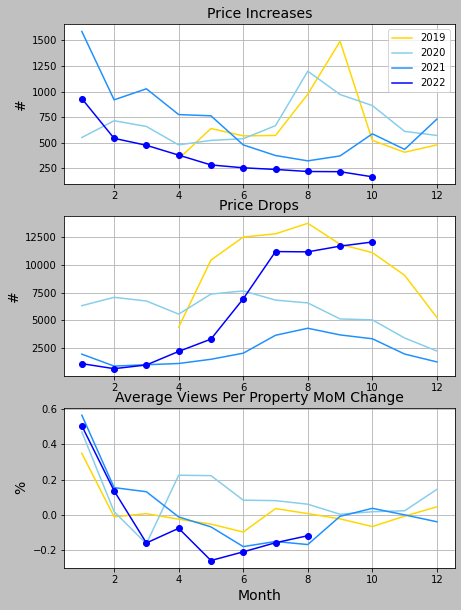

In [30]:
fig, axs = plt.subplots(3, figsize=(7,10),facecolor="silver") 

legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='skyblue',label='2020'),
                   Line2D([0], [0], color='dodgerblue', label='2021'),
                   Line2D([0], [0], color='blue',label='2022')]
axs[0].legend(handles=legend_elements, loc='best')


axs[0].plot(inv_19['Month'], inv_19['price_increased_count'], color='gold')
axs[0].plot(inv_20['Month'], inv_20['price_increased_count'], color='skyblue')
axs[0].plot(inv_21['Month'], inv_21['price_increased_count'], color='dodgerblue')
axs[0].plot(inv_22['Month'], inv_22['price_increased_count'], color='blue', marker='o')
axs[0].set_title('Price Increases', fontsize=14)
axs[0].grid(True)
axs[0].set_ylabel('#', fontsize=14)

axs[1].plot(inv_19['Month'], inv_19['price_reduced_count'], color='gold')
axs[1].plot(inv_20['Month'], inv_20['price_reduced_count'], color='skyblue')
axs[1].plot(inv_21['Month'], inv_21['price_reduced_count'], color='dodgerblue')
axs[1].plot(inv_22['Month'], inv_22['price_reduced_count'], color='blue', marker='o')
axs[1].set_title('Price Drops', fontsize=14)
axs[1].grid(True)
axs[1].set_ylabel('#', fontsize=14)

axs[2].plot(heat_19['Month'], heat_19['ldp_unique_viewers_per_property_mm'], color='gold')
axs[2].plot(heat_20['Month'], heat_20['ldp_unique_viewers_per_property_mm'], color='skyblue')
axs[2].plot(heat_21['Month'], heat_21['ldp_unique_viewers_per_property_mm'], color='dodgerblue')
axs[2].plot(heat_22['Month'], heat_22['ldp_unique_viewers_per_property_mm'], color='blue', marker='o')
axs[2].set_title('Average Views Per Property MoM Change', fontsize=14)
axs[2].grid(True)
axs[2].set_ylabel('%', fontsize=14)



plt.xlabel('Month', fontsize=14)

plt.savefig("prices.png", dpi = 150,bbox_inches='tight')
plt.show()

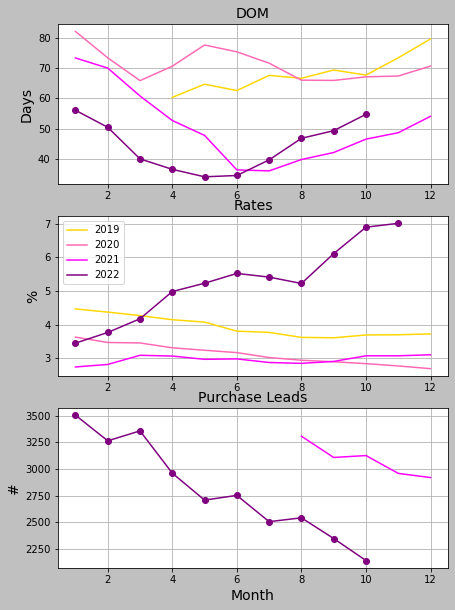

In [31]:
fig, axs = plt.subplots(3, figsize=(7,10),facecolor="silver") 

legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='hotpink',label='2020'),
                   Line2D([0], [0], color='magenta', label='2021'),
                   Line2D([0], [0], color='purple',label='2022')]
axs[1].legend(handles=legend_elements, loc='best')

axs[0].plot(inv_19['Month'], inv_19['median_days_on_market'], color='gold')
axs[0].plot(inv_20['Month'], inv_20['median_days_on_market'], color='hotpink')
axs[0].plot(inv_21['Month'], inv_21['median_days_on_market'], color='magenta')
axs[0].plot(inv_22['Month'], inv_22['median_days_on_market'], color='purple', marker='o')
axs[0].set_title('DOM', fontsize=14)
axs[0].grid(True)
axs[0].set_ylabel('Days', fontsize=14)

axs[1].plot(rate_19['Month'], rate_19['rate'], color='gold')
axs[1].plot(rate_20['Month'], rate_20['rate'], color='hotpink')
axs[1].plot(rate_21['Month'], rate_21['rate'], color='magenta')
axs[1].plot(rate_22['Month'], rate_22['rate'], color='purple', marker='o')
axs[1].set_title('Rates', fontsize=14)
axs[1].set_ylabel('%', fontsize=14)
axs[1].grid(True)

axs[2].plot(new_19['Month'], new_19['Id'], color='gold')
axs[2].plot(new_20['Month'], new_20['Id'], color='hotpink')
axs[2].plot(new_21['Month'], new_21['Id'], color='magenta')
axs[2].plot(new_22['Month'][new_22['YYYYMM']<int(current_yyyymm)], new_22['Id'][new_22['YYYYMM']<int(current_yyyymm)], color='purple', marker='o')
axs[2].set_title('Purchase Leads', fontsize=14)
axs[2].set_ylabel('#', fontsize=14)
axs[2].grid(True)

plt.xlabel('Month', fontsize=14)



plt.savefig("dom.png", dpi = 150,bbox_inches='tight')
plt.show()

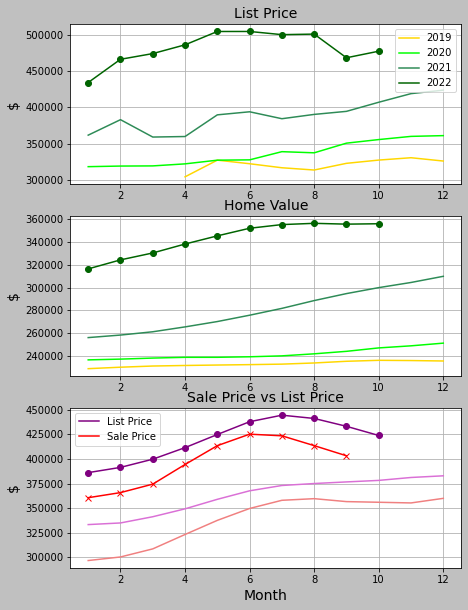

In [48]:
fig, axs = plt.subplots(3, figsize=(7,10),facecolor="silver") 

legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='lime',label='2020'),
                   Line2D([0], [0], color='seagreen', label='2021'),
                   Line2D([0], [0], color='darkgreen',label='2022')]

axs[0].legend(handles=legend_elements, loc='upper right')
axs[0].plot(inv_19['Month'], inv_19['median_listing_price'], color='gold')
axs[0].plot(inv_20['Month'], inv_20['median_listing_price'], color='lime')
axs[0].plot(inv_21['Month'], inv_21['median_listing_price'], color='seagreen')
axs[0].plot(inv_22['Month'], inv_22['median_listing_price'], color='darkgreen', marker='o')
axs[0].set_title('List Price', fontsize=14)
axs[0].grid(True)
axs[0].set_ylabel('$', fontsize=14)

axs[1].plot(vf_19['Month'], vf_19['HomeValue'], color='gold')
axs[1].plot(vf_20['Month'], vf_20['HomeValue'], color='lime')
axs[1].plot(vf_21['Month'], vf_21['HomeValue'], color='seagreen')
axs[1].plot(vf_22['Month'], vf_22['HomeValue'], color='darkgreen', marker='o')
axs[1].set_title('Home Value', fontsize=14)
axs[1].grid(True)
axs[1].set_ylabel('$', fontsize=14)

legend_elements2 = [
                   Line2D([0], [0], color='purple', label='List Price'),
                   Line2D([0], [0], color='red',label='Sale Price')]

axs[2].legend(handles=legend_elements2, loc='best')
axs[2].plot(listprice_22['Month'], listprice_22['ListPrice'], color='purple', marker='o')
axs[2].plot(saleprice_22['Month'], saleprice_22['SalePrice'], color='red', marker='x')
axs[2].plot(listprice_21['Month'], listprice_21['ListPrice'], color='orchid')
axs[2].plot(saleprice_21['Month'], saleprice_21['SalePrice'], color='lightcoral')
axs[2].set_title('Sale Price vs List Price', fontsize=14)
axs[2].grid(True)
axs[2].set_ylabel('$', fontsize=14)

plt.xlabel('Month', fontsize=14)



plt.savefig("value.png", dpi = 150,bbox_inches='tight')
plt.show()



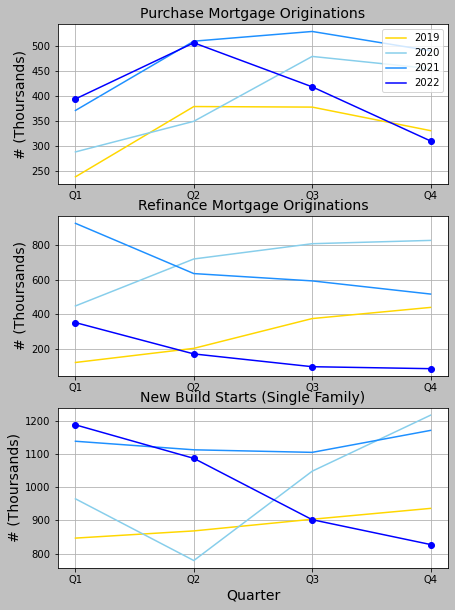

In [33]:
fig, axs = plt.subplots(3, figsize=(7,10),facecolor="silver") 

legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='skyblue',label='2020'),
                   Line2D([0], [0], color='dodgerblue', label='2021'),
                   Line2D([0], [0], color='blue',label='2022')]

axs[0].legend(handles=legend_elements, loc='upper right')
axs[0].plot(fannie_19['quarter'], fannie_19['purch_mort'], color='gold')
axs[0].plot(fannie_20['quarter'], fannie_20['purch_mort'], color='skyblue')
axs[0].plot(fannie_21['quarter'], fannie_21['purch_mort'], color='dodgerblue')
axs[0].plot(fannie_22['quarter'], fannie_22['purch_mort'], color='blue', marker='o')
axs[0].set_title('Purchase Mortgage Originations', fontsize=14)
axs[0].grid(True)
axs[0].set_ylabel('# (Thoursands)', fontsize=14)

axs[1].plot(fannie_19['quarter'], fannie_19['refi_mort'], color='gold')
axs[1].plot(fannie_20['quarter'], fannie_20['refi_mort'], color='skyblue')
axs[1].plot(fannie_21['quarter'], fannie_21['refi_mort'], color='dodgerblue')
axs[1].plot(fannie_22['quarter'], fannie_22['refi_mort'], color='blue', marker='o')
axs[1].set_title('Refinance Mortgage Originations', fontsize=14)
axs[1].grid(True)
axs[1].set_ylabel('# (Thoursands)', fontsize=14)


axs[2].plot(fannie_19['quarter'], fannie_19['new_home_starts'], color='gold')
axs[2].plot(fannie_20['quarter'], fannie_20['new_home_starts'], color='skyblue')
axs[2].plot(fannie_21['quarter'], fannie_21['new_home_starts'], color='dodgerblue')
axs[2].plot(fannie_22['quarter'], fannie_22['new_home_starts'], color='blue', marker='o')
axs[2].set_title('New Build Starts (Single Family)', fontsize=14)
axs[2].grid(True)
axs[2].set_ylabel('# (Thoursands)', fontsize=14)

plt.xlabel('Quarter', fontsize=14)



plt.savefig("fannie.png", dpi = 150,bbox_inches='tight')
plt.show()



In [34]:
# with pd.ExcelWriter(r'C:\Users\chris.mavor\Desktop\01.Projects\Marketing\Market_Trends\MarketData.xlsx') as writer:  
#     stacked.to_excel(writer, sheet_name='Detail',index = False)
    
with pd.ExcelWriter(r'C:\Users\chris.mavor\Desktop\01.Projects\Marketing\Market_Trends\MarketData_'+current_yyyymm+'.xlsx', engine='xlsxwriter') as writer:

# Convert the dataframe to an XlsxWriter Excel object.
    stacked_value_and_forecast.to_excel(writer, sheet_name='Value and Forecast')
    stacked_hotness.to_excel(writer, sheet_name='Hotness')
    stacked_inventory.to_excel(writer, sheet_name='Inventory')
    stacked_rates.to_excel(writer, sheet_name='Rates')
    stacked_sales.to_excel(writer, sheet_name='Sales')

    s = pd.DataFrame(data = [1]) 

    s.to_excel(writer, sheet_name='Charts')
    # Get the xlsxwriter workbook and worksheet objects.
    workbook  = writer.book
    worksheet = writer.sheets['Charts']

    # Insert an image.
    worksheet.insert_image('A1', 'listings.png')
    worksheet.insert_image('K1', 'prices.png')
    worksheet.insert_image('U1', 'dom.png')
    worksheet.insert_image('AE1', 'value.png')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
# writer = pd.ExcelWriter('python_plot.xlsx', engine = 'xlsxwriter')
# # worksheet = writer.sheets['Sheet1']
# writer.insert_image('A1','listings.png')
# writer.insert_image('B2','prices.png')
# writer.insert_image('C3','dom.png')


c:\Users\chris.mavor\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


# Benchmarking


In [35]:
sql_file = open(r"C:\Users\chris.mavor\Desktop\04.Reporting\QC Submittal\QC.Production Report.sql")
sql_as_string = """EXEC [Mortgage].[dbo].[Encompass_Production_Report]"""

In [36]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=ARCUDB;'
                      'Database=Mortgage;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
df = pd.read_sql_query(sql_as_string,conn)
df.head()

,Loan Number,Borr Name,CLOSING DATE,EST CLOSING DATE,Loan Folder Name,Loan Status,Last Finished Milestone,Last Finished Milestone Date,Date File Started,PROCESSED MILESTONE DATE,SUBMITTED MILESTONE DATE,Milestone Date - Resubmittal,Underwriting Sign Off Date,FUNDED MILESTONE DATE,DENIAL DATE,Milestone Date - Ready for Docs,Milestone Date - Cond. Approval,Closing Docs REGZ Loan Info Disbursement Date,Loan Officer,Loan Processor,Loan Purpose,Loan Program,Loan Amount,APPROVED MILESTONE DATE,Loan Closer,Milestone Date - Disclosures,Initial Disclosure Due Date,User Who Completed Task - Who Scheduled Loan Closing,Lock Expiration Date,UW Form - Date 1,UW Form - Resubmitted 1,Membership Number,Subject Property Address,On Hold Date,On Hold Reason,On Hold Removal date,CLOSING COST PROGRAM,Underwriter Name,Underwriting Counter Offer Date,Underwriting Counteroffer Status,CX.UW.RECOMMENDDECLINE,CX.UW.RECOMMENDDECLINEDATE,Milestone Date - Disclosures Sent,TIL Intl Disclosure Provided Date,TIL Intl TIL Disclosure Rcvd Date,Underwriting Credit Approval Date,VA Loan Summ Credit Score,TIL Redisclosure Provided Date,Revised GFE Due Date,TIL Redisclosure Rcvd Date,Broker Referral Name,CX.RMC.COUNTER.CONTACT1,CX.RMC.COUNTER.CONTACT2,CX.RMC.COUNTER.CONTACT3,CX.RMC.NOI.CONTACT1,CX.RMC.NOI.CONTACT2,CX.RMC.NOI.CONTACT3,CX.INFOSHEET.NEWBUILD,CX.PORTLOAND,Closing Disclosure Sent Date,GFE APPLICATION DATE,Income Total Mo Income,Milestone Date - Prequalification,CX.MLO.PREAPP.COMPLETE,CX.MLO.PREAPP.COMPLETEDATE,DOCUMENT DATE,REGZ Loan Info Rescission Date,REGZ Loan Info Document Signing Date,Information Sheet Escrow,Mavent Compliance Review Result,Funding Funder Name,BUYERS AGENT NAME,BUYERS AGENT CONTACT NAME,HELOC Initial Advance,Trans Details Refinance,Disclosure Required?,Disclosure Status,Disclosure Exception,Decision Due Date,Decision Status,Days Remaining for Decision,Credit Exception,Overall Status,Resubmittal Indicator,Credit Pulled No App,TBD,Projected Closing Date,Days From Closing,Closing Age Bucket,MembershipFlag,Credit Pulled,Secondary,WeekEnding_FileStarted,WeekEnding_SentToProcessing,WeekEnding_Submitted,WeekEnding_PreApprovalComplete,WeekEnding_Resubmitted,WeekEnding_Denial,WeekEnding_ReadyForDocs,WeekEnding_Approval,YearMonth_FileStarted,YearMonth_Submitted,YearMonth_Funded,YearMonth_SenttoProcessing,YearMonth_Approval,YearMonth_Resubmittal,YearMonth_ReadyForDocs,YearMonth_REGZ,DeniedBy,LTVCat,Conforming,Projected_SentToProc,LoanType,SpecialtyProgram,YearMonth_Prequalification,LargeLoans,CX.MLO.PREAPP.STATUS
0,189372020,Shannon R. Stevenson,2020-01-18,2020-02-06,Completed,Loan Originated,Completion,2020-02-10 11:56:39,2020-01-03,2020-01-07,2020-01-07,2020-01-08,2020-01-08,2020-01-24,None,2020-01-09,2020-01-08,2020-01-24,Donna J Hooker,Christy Garden,Cash-Out Refinance,HELOC 2nd - Advance 5/15,42000.0,2020-01-08,Anna Karaffa,None,2020-01-09,akaraffa,2020-03-05,,,201298,625 Bent Oak Drive,None,,None,HELOC Advance,Michael Bennett,None,,None,,2020-01-06,None,None,2020-01-08,757,None,None,None,,None,None,None,None,None,None,None,None,None,2020-01-06,11024.18,2020-01-06,,1900-01-01,2020-01-18,2020-01-23,2020-01-18,No Impounds,WARNING,Anna Karaffa,,,0,NaN,Disclosure Required,NA,NA,2020-02-05,NA,NaN,No,Funded,1,False,FALSE,2020-01-18,-1031.0,B. Past Due,Valid,Yes,NA,Week Ending 01/04/2020,Week Ending 01/11/2020,Week Ending 01/11/2020,Week Ending 01/06/1900,Week Ending 01/11/2020,None,Week Ending 01/11/2020,Week Ending 01/11/2020,202001,202001,202001,202001,202001,202001,202001,202001,NA,<90,Non-Conforming,2020-01-14,HELOC,NA,202001,0,
1,189052020,Subbiah Venkatachalam,2020-02-12,2020-02-11,Completed,Loan Originated,Completion,2020-03-13 11:36:59,2020-01-02,2020-01-22,2020-01-23,2020-02-04,2020-02-04,2020-02-18,None,2020-02-10,2020-01-23,2020-02-18,Allison Ballman,Jeffrey Duncan,NoCash-Out Refinance,R/T Refinance 15-YR,101000.0,2020-02-04,Ashley Botello,None,2020-01-06,abotello,2020-02-18,,,10107876,933 Brentwood Dr,None,,None,Rate Term 1st,Micha

In [37]:
df = df[df['YearMonth_Funded']!="None"]

df['YearMonth_Funded'] = df['YearMonth_Funded'].fillna(0).astype(float).astype(int)

df_internal = df[(df['YearMonth_Funded'].astype(int)>201900)&(df['Loan Purpose']=='Purchase')][['YearMonth_Funded','Loan Amount','Loan Number']].groupby('YearMonth_Funded').agg({'Loan Number':'count','Loan Amount':np.average}).reset_index()

df_internal['YYYYMM'] = df_internal['YearMonth_Funded'].astype(int)
df_internal['Year'] = df_internal['YYYYMM'].astype(str).str[0:4].astype(int)
df_internal['Month'] = df_internal['YYYYMM'].astype(str).str[4:6].astype(int)
df_internal['YYYYMM'] = df_internal['YYYYMM'].astype(int)

df_internal_19 = df_internal[df_internal['Year']==2019]
df_internal_20 = df_internal[df_internal['Year']==2020]
df_internal_21 = df_internal[df_internal['Year']==2021]
df_internal_22 = df_internal[df_internal['Year']==2022]
df_internal_23 = df_internal[df_internal['Year']==2023]

In [38]:
df_internal_22.head()

,YearMonth_Funded,Loan Number,Loan Amount,YYYYMM,Year,Month
23,202201,6,322121.666667,202201,2022,1
24,202202,14,271317.857143,202202,2022,2
25,202203,5,346640.000000,202203,2022,3
26,202204,6,232878.000000,202204,2022,4
27,202205,14,328481.214286,202205,2022,5


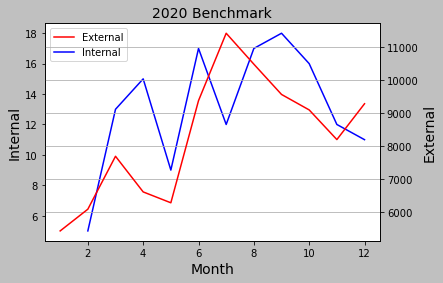

In [39]:
legend_elements = [Line2D([0], [0], color='red', label='External'),
                   Line2D([0], [0], color='blue',label='Internal')]

fig, ax1 = plt.subplots(facecolor="silver")

ax2 = ax1.twinx()

ax1.legend(handles=legend_elements, loc='best')
ax1.plot(df_internal_20['Month'], df_internal_20['Loan Number'], color='blue')
ax2.plot(sale_20['Month'], sale_20['Sales'], color='red')
# plt.plot(df_internal_22['Month'], df_internal_22['Loan Number'], color='blue')
plt.title('2020 Benchmark', fontsize=14)
plt.grid(True)
ax1.set_ylabel('Internal', fontsize=14)
ax2.set_ylabel('External', fontsize=14)

ax1.set_xlabel('Month', fontsize=14)



plt.savefig("benchmark1.png", dpi = 150,bbox_inches='tight')
plt.show()



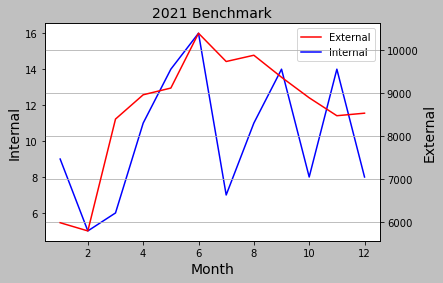

In [40]:
legend_elements = [Line2D([0], [0], color='red', label='External'),
                   Line2D([0], [0], color='blue',label='Internal')]

fig, ax1 = plt.subplots(facecolor="silver")

ax2 = ax1.twinx()

ax1.legend(handles=legend_elements, loc='best')
ax1.plot(df_internal_21['Month'], df_internal_21['Loan Number'], color='blue')
ax2.plot(sale_21['Month'], sale_21['Sales'], color='red')
# plt.plot(df_internal_22['Month'], df_internal_22['Loan Number'], color='blue')
plt.title('2021 Benchmark', fontsize=14)
plt.grid(True)
ax1.set_ylabel('Internal', fontsize=14)
ax2.set_ylabel('External', fontsize=14)

ax1.set_xlabel('Month', fontsize=14)



plt.savefig("benchmark2.png", dpi = 150,bbox_inches='tight')
plt.show()

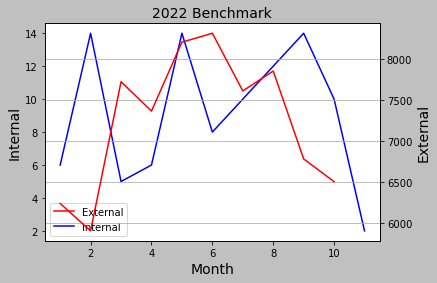

In [41]:
legend_elements = [Line2D([0], [0], color='red', label='External'),
                   Line2D([0], [0], color='blue',label='Internal')]

fig, ax1 = plt.subplots(facecolor="silver")

ax2 = ax1.twinx()

ax1.legend(handles=legend_elements, loc='best')
ax1.plot(df_internal_22['Month'], df_internal_22['Loan Number'], color='blue')
ax2.plot(sale_22['Month'], sale_22['Sales'], color='red')
plt.title('2022 Benchmark', fontsize=14)
plt.grid(True)
ax1.set_ylabel('Internal', fontsize=14)
ax2.set_ylabel('External', fontsize=14)

ax1.set_xlabel('Month', fontsize=14)



plt.savefig("benchmark3.png", dpi = 150,bbox_inches='tight')
plt.show()

In [42]:
# vf.head()
# heat.head()
# inv.head()
# rate.head()
# sale.head()
# new.head()
print(new.columns)

Index(['YYYYMM', 'Id', 'Year', 'Month'], dtype='object')


In [43]:
new.head()

,YYYYMM,Id,Year,Month
0,202108,3306,2021,8
1,202109,3107,2021,9
2,202110,3125,2021,10
3,202111,2958,2021,11
4,202112,2919,2021,12


In [44]:
all = sale.merge(new, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all.merge(vf, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all.merge(inv, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all.merge(heat, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all.merge(rate, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all.merge(saleprice, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all.merge(listprice, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
# all = all.merge(df_internal, left_on=['YYYYMM'], right_on=['YYYYMM'],how = 'left')
all = all[['YYYYMM', 'Id','Sales','rate', 'HomeValue','median_listing_price', 'active_listing_count'
        ,'new_listing_count', 'price_increased_count', 'price_reduced_count', 'median_days_on_market'
        ,'hotness_rank', 'supply_score', 'demand_score', 'ldp_unique_viewers_per_property_mm','SalePrice','ListPrice'
        # ,'Loan Number', 'Loan Amount'
        ]].sort_values(by='YYYYMM', axis=0, ascending=True).reset_index()

all = all[all['YYYYMM']>201900].sort_values(by='YYYYMM', axis=0, ascending=True).reset_index()
        # .iloc[:18]
all.head(30)

c:\Users\chris.mavor\Anaconda3\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Month_x', 'Year_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,level_0,index,YYYYMM,Id,Sales,rate,HomeValue,median_listing_price,active_listing_count,new_listing_count,price_increased_count,price_reduced_count,median_days_on_market,hotness_rank,supply_score,demand_score,ldp_unique_viewers_per_property_mm,SalePrice,ListPrice
0,131,131,201901,NaN,4609.0,4.4640,229047.671717,NaN,NaN,NaN,NaN,NaN,NaN,2644.820628,65.926788,77.562880,0.349605,248483.0,316258.0
1,132,132,201902,NaN,5519.0,4.3700,230338.025189,NaN,NaN,NaN,NaN,NaN,NaN,2738.142857,65.505941,75.635312,-0.009700,248483.0,316425.0
2,133,133,201903,NaN,7326.0,4.2650,231358.274559,NaN,NaN,NaN,NaN,NaN,NaN,2932.776786,63.609203,74.147690,0.007613,251167.0,319758.0
3,134,134,201904,NaN,8117.0,4.1425,231843.753149,304142.103448,11539.0,6140.0,344.0,4396.0,60.318182,3283.155556,59.481049,73.210680,-0.023452,258633.0,326500.0
4,135,135,201905,NaN,9269.0,4.0720,232228.846348,327147.891358,25663.0,13232.0,640.0,10400.0,64.669136,3489.937500,56.752134,72.871458,-0.051373,266967.0,331667.0
5,136,136,201906,NaN,8408.0,3.8025,232581.788413,322204.473815,27331.0,13620.0,568.0,12464.0,62.566085,3404.513274,57.401541,73.036727,-0.096262,273012.0,334967.0
6,137,137,201907,NaN,9486.0,3.7650,233017.783375,316647.598015,28323.0,12520.0,572.0,12752.0,67.575682,3334.831858,59.588749,72.558573,0.036631,276212.0,332967.0
7,138,138,201908,NaN,9040.0,3.6160,234033.506297,313529.163265,27920.0,12792.0,976.0,13692.0,66.609756,3271.964602,60.735653,72.166528,0.008210,275545.0,329600.0
8,139,139,201909,NaN,7522.0,3.6050,235515.120907,322754.144279,26886.0,10984.0,1492.0,11820.0,69.355556,3520.115556,57.181929,71.985840,-0.021842,270833.0,326267.0
9,140,140,201910,NaN,7633.0,3.6880,236357.138889,327260.367901,27064.0,10088.0,524.0,11068.0,67.676543,3537.280000,57.700997,71.047004,-0.065170,268000.0,324267.0


In [45]:
all["%_id"] = all['Id'].pct_change()
all["%_HomeValue"] = all['HomeValue'].pct_change()
all["%_active_listing_count"] = all['active_listing_count'].pct_change()
all["%_new_listing_count"] = all['new_listing_count'].pct_change()
all["%_median_days_on_market"] = all['median_days_on_market'].pct_change()
all["%_rate"] = all['rate'].pct_change()
all["%_Sales"] = all['Sales'].pct_change()
correlation = all.corr()


<AxesSubplot:>

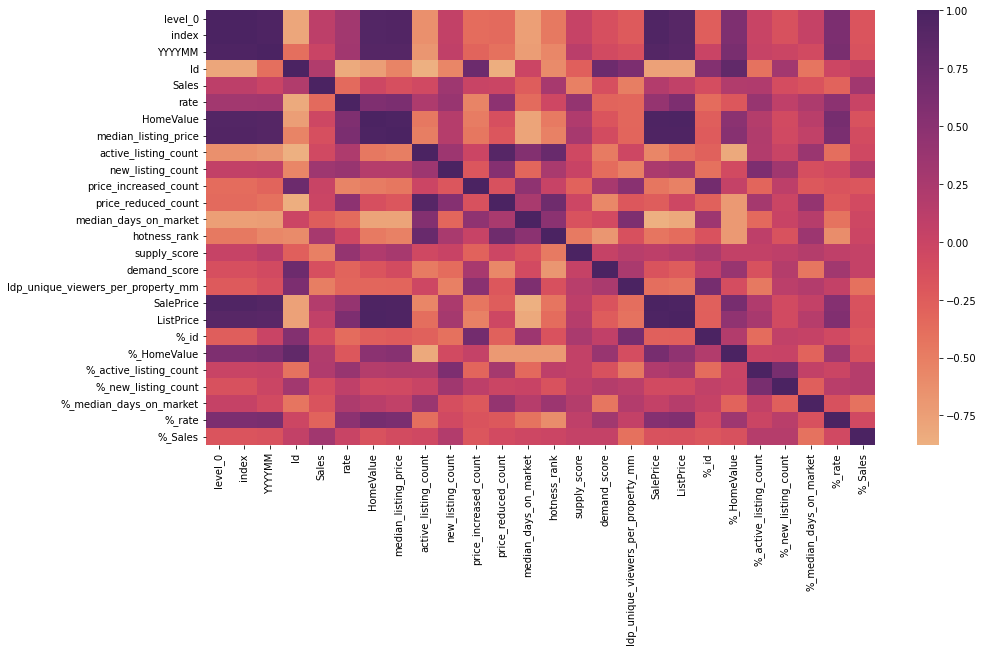

In [46]:
plt.figure(figsize = (15,8))
sns.heatmap(correlation,cmap = 'flare')

KeyError: 'Loan Number'

<Figure size 504x479.952 with 0 Axes>

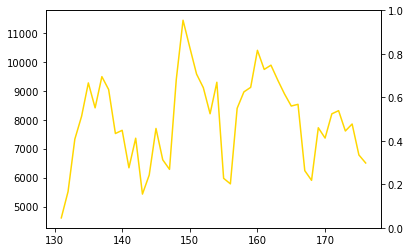

In [47]:
plt.figure(figsize=(7,6.666),facecolor="silver") 
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
# plt.legend(handles=legend_elements, loc='upper right')
ax1.plot(all['index'], all['Sales'], color='gold')
ax2.plot(all['index'], all['Loan Number'], color='purple')
ax1.grid(True)
sns.regplot(all['index'],all['Sales'],line_kws={'color':'red'})


# plt.savefig("value.png", dpi = 150,bbox_inches='tight')
plt.show()


## Linear Regression


In [ ]:
x=all['index']
y1=all['Sales'].fillna(0)
y2=all['Loan Number'].fillna(0)
n = np.size(x)

x_mean = np.mean(x)
y1_mean = np.mean(y1)
y2_mean = np.mean(y2)

  
Sxy1 = np.sum(x*y1)- n*x_mean*y1_mean
Sxy2 = np.sum(x*y2)- n*x_mean*y2_mean
Sxx = np.sum(x*x)-n*x_mean*x_mean
  
b1 = Sxy1/Sxx
b2 = Sxy2/Sxx
a1 = y1_mean-b1*x_mean
a2 = y2_mean-b2*x_mean

print('slope b1 is', b1)
print('intercept a1 is', a1)
print('slope b2 is', b2)
print('intercept a2 is', a2)

## linear

In [ ]:

y1_pred = b1 * x + a1
y2_pred = b2 * x + a2
legend_elements = [Line2D([0], [0], color='red', label='Sales'),
                   Line2D([0], [0], color='blue',label='Leads')]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.legend(handles=legend_elements, loc='best')
ax1.scatter(x, y1, color = 'red')
ax2.scatter(x, y2, color = 'blue')
ax1.plot(x, y1_pred, color = 'coral')
ax2.plot(x, y2_pred, color = 'dodgerblue')
plt.xlabel('X')
plt.ylabel('y')

## Polynomial Regression

In [ ]:
x_0 = x[:, np.newaxis]
y1_0 = y1[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x_0)

model = LinearRegression()
model.fit(x_poly, y1_0)
y1_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y1,y1_poly_pred))
r2 = r2_score(y1,y1_poly_pred)
print(rmse)
print(r2)

plt.scatter(x_0, y1_0)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_0,y1_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x_0, y_poly_pred, color='m')
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
legend_elements = [Line2D([0], [0], color='blue', label='Market Sales'),
                   Line2D([0], [0], color='coral',label='EECU')]

plt.legend(handles=legend_elements, loc='best')
lin_1 = LinearRegression()
lin_1.fit(x, y1)
poly = PolynomialFeatures(degree = 8)
X_poly = poly.fit_transform(x)
poly.fit(X_poly, y1)
lin2 = LinearRegression()
lin2.fit(X_poly, y1)
y2_pred_poly = lin2.predict(poly.fit_transform(x))
# ax1.scatter(x, y1, color = 'blue')
ax1.plot(x, lin2.predict(poly.fit_transform(x)), color = 'dodgerblue')



lin_2 = LinearRegression()
lin_2.fit(x, y2)
poly = PolynomialFeatures(degree = 8)
X_poly = poly.fit_transform(x)
poly.fit(X_poly, y2)
lin2 = LinearRegression()
lin2.fit(X_poly, y2)
y2_pred_poly = lin2.predict(poly.fit_transform(x))
# ax2.scatter(x, y2, color = 'red')
ax2.plot(x, lin2.predict(poly.fit_transform(x)), color = 'coral')

plt.title('Polynomial Regression')
plt.xlabel('Time')
# ax1.ylabel('leads')
# ax2.ylabel('leads')
 
plt.show()
plt.savefig("Benchmark.png", dpi = 150,bbox_inches='tight')


# Forecasting


In [ ]:

import sklearn.linear_model as ll

data = new.copy()
X = data.iloc[:,2:4]
y = data.iloc[:,1]

month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthmap = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

data["Month"] = data['Month'].map(monthmap)

for i, m in enumerate(data.iloc[:,3]):
    data.iloc[i,3] = month.index(m)

X = data.iloc[:,2:4]
lr = ll.LinearRegression()
lr.fit(X, y)

######### TEST DATA ##########
X_test = [[1, 2020], [2, 2020]]
X_test = pd.DataFrame(X_test, columns=['Month', 'Year'])

y_test = lr.predict(X_test)
print(y_test)
# data.head()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pylab as plt
# %matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6

In [ ]:

# df['Month'] = pd.to_datetime(df['YYYYMM'], format='%Y%m', errors='coerce').dropna()
# # df.head()
# workdata = df[["Month","HomeValue"]].set_index(["Month"])
# # workdata = workdata.drop(["YYYYMM"], axis=1).copy()
# # workdata.head()
# ts = workdata.copy()

In [ ]:
# ts = ts.dropna()

In [ ]:

# Usually, when performing time series analysis, a time series is not split into training and test set, because all the time series is needed to get a good forecast.
# However, in this tutorial, I split the time series into two parts — training and test — in order to test the performance of the tested models. 
# I take the first part of the time series as training set and the second part as test set.
# Each model will be trained on the trained set and tested on the test set.

# ts_train = ts[:'2020-02-01']
# ts_test = ts['2020-03-01':]
# ts_forecast = ts['2020-03-01':'2021-12-01']

In [ ]:

# Usually, when performing time series analysis, a time series is not split into training and test set, because all the time series is needed to get a good forecast.
# However, in this tutorial, I split the time series into two parts — training and test — in order to test the performance of the tested models. 
# I take the first part of the time series as training set and the second part as test set.
# # Each model will be trained on the trained set and tested on the test set.

# ts_train = ts[:'2020-02-01']
# ts_test = ts['2020-03-01':]
# ts_forecast = ts['2020-03-01':'2021-12-01']

In [ ]:
# A stationary time series is a time series that has stable/constant statistical properties, such as mean and variance over time.
# Long-term Forecasting is possible on a stationary time series. 
# Thus, I must test whether the training time series is stationary or not. 
# This can be done through the Augmented Dickey-Fuller Test, implemented by the adfuller() function of the statsmodels package. 
# The adfuller() test returns the test statistics adf, the pvalue and the critical_values. 
# The pvalue specifies whether the test result is meaningful or not. If pvalue < alpha then the test has sense, where alpha is a small value, e.g. 0.05.
# In the Augmented Dickey-Fuller Test the null hypothesis is that the time series is not stationary. 
# The null hypothesis is true if the test statistics adf is greater than critical values. 
# Thus, I define a function, called check_stationarity(), which checks whether a time series is stationary or not.


# from statsmodels.tsa.stattools import adfuller
# import numpy as np
# def check_stationarity(ts):
#     dftest = adfuller(ts)
#     adf = dftest[0]
#     pvalue = dftest[1]
#     critical_value = dftest[4]['5%']
#     if (pvalue < 0.05) and (adf < critical_value):
#         print('The series is stationary')
#     else:
#         print('The series is NOT stationary')

In [ ]:
# I call the function with my time series as parameter:
# check_stationarity(ts_train)

In [ ]:
# Since the time series is not stationary, I transform it, by differencing once and I check again for stationarity.
# ts_diff = ts_train.diff()
# ts_diff.dropna(inplace=True)
# check_stationarity(ts_diff)

In [ ]:
# # Now, the time series is stationary, thus I can set the difference order for the training model to 1.
# d = 1

# # I plot the differenced time series:
# plt.plot(ts_diff)
# plt.title('Differenced Time Series')
# plt.grid()
# plt.show()

## 1 — Manual setting of model parameters and multi-step forecasting


In [ ]:
# The first approach involves the use of the Seasonal Autoregressive Integrated Moving Average (SARIMA) model to forecast the number of tourists arrivals to Italy.
# The SARIMA model needs three parameters: p, d and q. The value of d has been already set, because it specifies the integration order needed to make the time series stationary.
# In this approach, I try to set the model p and q parameters by manually looking at the Partial Autocorrelation and Correlation graphs.
# Partial Autocorrelation (PACF) is used to calculate the p parameter. I plot the PACF graph through the statsmodels function plot_pacf().

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_pacf(ts_diff, lags =12)
# plt.show()

In [ ]:
# I note that the maximum value of PACF out the confidence intervals (in light blue) is 10. Thus, I try p = 10.
# p = 10

In [ ]:
# Now I plot the Autocorrelation (ACF) graph to calculate the value of q.
# plot_acf(ts_diff, lags =12)
# plt.show()

In [ ]:
# # The maximum value of ACF out of confidence intervals is 11. However, I try to be more conservative and I try q = 7.
# q = 7

In [ ]:
# # Once set the p, q and d parameters, I can run the model.
# # I exploit the SARIMAX model of the statsmodels. 
# # I create the model and I fit with the training time series.
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(ts_train, order=(p,d,q))
# model_fit = model.fit()

In [ ]:
# # I can use the trained model for forecasting. I will exploit the model to forecast a number of steps equal to the length of the test time series.
# n_test = ts_test.shape[0]
# ts_pred = model_fit.forecast(steps=n_test)
# # Now I can plot the comparison between the test time series and the predicted values.
# plt.plot(ts_pred, label='prediction')
# plt.plot(ts_test, label='actual')
# # plt.plot(ts_train, label='actual')

# plt.title('Multi-step Forecasting (manual parameters)')
# plt.legend()
# plt.grid()
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# # To evaluate the model, I calculate the Normalized Root Mean Square Error (NRMSE) metrics.
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # nrmse = rmse(ts_pred_auto, ts_test)/(np.max(ts_test)-np.min(ts_test))

# rms = sqrt(mean_squared_error(ts_pred, ts_test))/(np.max(ts_test)-np.min(ts_test))
# rms

## 3 - Automatic setting of model parameters and multi-step forecasting

In [ ]:

# # In this case, I exploit the pmdarima Python library for the automatic tuning of SARIMA p and q parameters. 
# # In detail, I exploit the auto_arima() function, which receives as input the test ranges for the p and q parameters, as well as other useful informations. 
# # I set stepwise=False in order to test all the possible combinations of p and q. In addition, I will set seasonal=True to use a SARIMA model.

# import pmdarima as pm
# stepwise_model = pm.auto_arima(ts_train,start_p=1, d=1, start_q=1,
#                             max_p=12, max_q=12,
#                             m=12,
#                             seasonal=True, stationary=False,
#                             information_criterion='aic',
#                             stepwise=False,
#                             suppress_warnings=True)
# stepwise_model.fit(ts_train)

In [ ]:
# The obtained model has the following parameters:
# ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)

In [ ]:
# # Now I use the best model for forecast.
# ts_pred_auto = stepwise_model.predict(n_periods=n_test)

In [ ]:
# # I plot results.
# plt.plot(ts_test.index,ts_pred_auto, label='auto sarima')
# plt.plot(ts_test, label='actual')
# plt.plot(ts_train, label='actual')

# plt.title('Single-step Forecasting (automatic parameters)')
# plt.grid()
# plt.xticks(rotation=90)
# plt.legend()
# plt.show()

In [ ]:
# model = SARIMAX(ts_train['TOTAL_PAID_SEVERITY'],
#                     order = (1, 1, 0),
#                     seasonal_order =(1, 1, 0, 12))
# result = model.fit()

# # Forecast for the next 3 years
# forecast = result.predict(start = 13,
#                     end = (len(workdata)-1) + 3 * 12,
#                     typ = 'levels').rename('Forecast')

# # Plot the forecast values
# workdata['TOTAL_PAID_SEVERITY'].plot(figsize = (12, 5), legend = True)
# forecast.plot(legend = True)
# print('Train off PreCovid')

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA

# model = SARIMAX(ts['TOTAL_PAID_SEVERITY'],
#                     order = (1, 1, 0),
#                     seasonal_order =(1, 1, 0, 12))
# result = model.fit()

# # Forecast for the next 3 years
# forecast = result.predict(start = 13,
#                     end = (len(workdata)-1) + 3 * 12,
#                     typ = 'levels').rename('Forecast')

# # Plot the forecast values
# workdata['TOTAL_PAID_SEVERITY'].plot(figsize = (12, 5), legend = True)
# forecast.plot(legend = True)
# print('Train off data with Covid')

# END

Acceleration of change in measures
This is to understand what is happening

In [ ]:
all.head()

In [ ]:
test_velocity = all[['YYYYMM','rate','median_days_on_market','median_listing_price']]
test_velocity['rate_speed']= test_velocity['rate'].diff()
test_velocity['rate_acc']= test_velocity['rate_speed'].diff()

test_velocity['dom_speed']= test_velocity['median_days_on_market'].diff()
test_velocity['dom_acc']= test_velocity['dom_speed'].diff()

test_velocity['list_speed']= test_velocity['median_listing_price'].diff()
test_velocity['list_acc']= test_velocity['list_speed'].diff()

test_velocity['YYYYMM'] = test_velocity['YYYYMM'].astype(int)
test_velocity['Year'] = test_velocity['YYYYMM'].astype(str).str[0:4].astype(int)
test_velocity['Month'] = test_velocity['YYYYMM'].astype(str).str[4:6].astype(int)
test_velocity['YYYYMM'] = test_velocity['YYYYMM'].astype(int)

test_velocity=test_velocity[['YYYYMM','Month','Year','rate','rate_speed','rate_acc','median_days_on_market','dom_speed','dom_acc','median_listing_price','list_speed','list_acc']]

test_velocity_19 = test_velocity[test_velocity['Year']==2019]
test_velocity_20 = test_velocity[test_velocity['Year']==2020]
test_velocity_21 = test_velocity[test_velocity['Year']==2021]
test_velocity_22 = test_velocity[test_velocity['Year']==2022]
test_velocity_23 = test_velocity[test_velocity['Year']==2023]

test_velocity.head(100)



In [ ]:
fig, axs = plt.subplots(3, figsize=(7,10),facecolor="silver") 

legend_elements = [Line2D([0], [0], color='gold', label='2019'),
                   Line2D([0], [0], color='lime',label='2020'),
                   Line2D([0], [0], color='seagreen', label='2021'),
                   Line2D([0], [0], color='darkgreen',label='2022')]

axs[0].legend(handles=legend_elements, loc='upper right')
axs[0].plot(test_velocity_19['Month'], test_velocity_19['rate_acc'], color='gold')
axs[0].plot(test_velocity_20['Month'], test_velocity_20['rate_acc'], color='lime')
axs[0].plot(test_velocity_21['Month'], test_velocity_21['rate_acc'], color='seagreen')
axs[0].plot(test_velocity_22['Month'], test_velocity_22['rate_acc'], color='darkgreen', marker='o')
axs[0].set_title('Rate', fontsize=14)
axs[0].grid(True)
axs[0].set_ylabel('Acceleration', fontsize=14)

# axs[1].plot(test_velocity_19['Month'], test_velocity_19['dom_acc'], color='gold')
# axs[1].plot(test_velocity_20['Month'], test_velocity_20['dom_acc'], color='lime')
# axs[1].plot(test_velocity_21['Month'], test_velocity_21['dom_acc'], color='seagreen')
axs[1].plot(test_velocity_22['Month'], test_velocity_22['dom_acc'], color='darkgreen', marker='o')
axs[1].set_title('DOM', fontsize=14)
axs[1].grid(True)
axs[1].set_ylabel('Acceleration', fontsize=14)

# axs[1].plot(test_velocity_19['Month'], test_velocity_19['dom_acc'], color='gold')
# axs[1].plot(test_velocity_20['Month'], test_velocity_20['dom_acc'], color='lime')
# axs[1].plot(test_velocity_21['Month'], test_velocity_21['dom_acc'], color='seagreen')
axs[2].plot(test_velocity_22['Month'], test_velocity_22['list_acc'], color='darkgreen', marker='o')
axs[2].set_title('list price', fontsize=14)
axs[2].grid(True)
axs[2].set_ylabel('Acceleration', fontsize=14)

plt.xlabel('Month', fontsize=14)



# plt.savefig("value.png", dpi = 150,bbox_inches='tight')
plt.show()